# Saint Louis Crime
## DATA620 Project 2
### Bryant Chang, Thomas Detzel, Erik Nylander

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
import networkx.algorithms.bipartite as bp

## Introduction and Findings

*Note: To hide/show code in this notebook, use the </> toggle button in the toolbar.*

In the 1990s Rick Rosenfeld and Norm White used police records to collect data on crime in St. Louis. They began with five homicides and recorded the names of all the individuals who had been involved as victims, suspects or witnesses. They then explored the files and recorded all the other crimes in which those same individuals appeared. This snowball process was continued until they had data on 557 crime events. Those events involved 870 participants of which: 569 appeared as victims 682 appeared as suspects 195 appeared as witnesses, and 41 were dual (they were recorded both as victims and suspects in the same crime. Their data appear, then, as an 870 by 557, individual by crime event matrix. Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.
In addition Rosenfeld and White recorded the sex of each individual. The data can be found at [here](http://konect.uni-koblenz.de/networks/moreno_crime) in a compressed format. We have uploaded the necessary files to the projects GitHub site to facilitate the analysis.

We found ??

## Importing the Crime Data

The crime data set that we have chosen to use is split amongst a number of different files. There are four main files that we worked with, the data on crimes, the data on the relationships of the people to the crimes, the names of the individuals, and the sex of the individuals. The following code imports the various files and uses the dataframe features of *pandas* to create our crime data set that is needed to build our graph.

In [2]:
# loading crime data
data_crime = "https://raw.githubusercontent.com/eriknylander99/DATA620_Group_Projects/master/data/moreno_crime/out.moreno_crime_crime"
crime = pd.read_csv(data_crime, delim_whitespace=True, header=None, skiprows=[0,1], names=['Person', 'Crime'])
# loading relationship data
data_rel = "https://raw.githubusercontent.com/eriknylander99/DATA620_Group_Projects/master/data/moreno_crime/rel.moreno_crime_crime.person.role"
crime['Relationship'] = pd.read_csv(data_rel, header=None)

crime.head()

,Person,Crime,Relationship
0,1,1,Suspect
1,1,2,Victim
2,1,3,Victim
3,1,4,Suspect
4,2,5,Victim


In [3]:
# Total number of people
len(crime.Person.unique())

829

In [4]:
# Total number of crimes
len(crime.Crime.unique())

551

In [5]:
# Count of how many crimes each person was involved in 
crime.Person.value_counts().head()

815    25
2      22
425    18
220    17
56     14
Name: Person, dtype: int64

In [6]:
# adding count 
crime['Count'] = crime.groupby(['Person'])['Crime'].transform('count')
crime.head()

,Person,Crime,Relationship,Count
0,1,1,Suspect,4
1,1,2,Victim,4
2,1,3,Victim,4
3,1,4,Suspect,4
4,2,5,Victim,22


In [10]:
## segregating attributes here to get a relationship count and a total crime count 
crime2 = crime
crime2['rel_count'] = crime2.groupby(['Person', 'Relationship'])['Crime'].transform('count')
crime2['crime_count'] = crime2.groupby(['Person'])['Crime'].transform('count')
del crime2['Count']
crime2.head()

,Person,Crime,Relationship,rel_count,crime_count
0,1,1,Suspect,2,4
1,1,2,Victim,2,4
2,1,3,Victim,2,4
3,1,4,Suspect,2,4
4,2,5,Victim,4,22


In [11]:
# loading name data
data_names = 'https://raw.githubusercontent.com/eriknylander99/DATA620_Group_Projects/master/data/moreno_crime/ent.moreno_crime_crime.person.name'
names = pd.read_csv(data_names, sep='\t', header=None)

# loading sex data
data_sex = 'https://raw.githubusercontent.com/eriknylander99/DATA620_Group_Projects/master/data/moreno_crime/ent.moreno_crime_crime.person.sex'
names['Sex'] = pd.read_csv(data_sex, header=None)
names.ix[names.Sex == 1, 'Sex'] = 'M'
names.ix[names.Sex == 0, 'Sex'] = 'F'

# replacing left nodes (people involved in a crime) with names and adding sex
# Right nodes stay as numbers to identify as crimes, not people
for i in range(0,len(names)):
    crime2.ix[crime2.Person == i+1, 'Sex'] = names.iloc[i][1]
    crime2.ix[crime2.Person == i+1, 'Person'] = names.iloc[i][0]
    
crime.head()

,Person,Crime,Relationship,rel_count,crime_count,Sex
0,AbelDennis,1,Suspect,2,4,M
1,AbelDennis,2,Victim,2,4,M
2,AbelDennis,3,Victim,2,4,M
3,AbelDennis,4,Suspect,2,4,M
4,AbramsChad,5,Victim,4,22,M


## Creating the Graph
Now that we have our dataframe of the crimes commited in the St. Louis data we can start to build our crime graph. We ran into problems using the default *networkX* tools for loading the data from our data frame. This led us to load in all of the nodes and edges by hand to get a true bipartite structure to our graph for the bipartite data.

### Loading Nodes and Edges Separately

We start by adding in our person and crime nodes to our empty graph individually. Once we have these nodes in the graph we then itterate over the data to add edges between all of the nodes.

In [34]:
## reloading data in bipartite fashion
G2 = nx.Graph()
# add person nodes
for i in range(len(crime2)): 
    G2.add_node(crime2.iloc[i][0],
                Relation=crime2.iloc[i][2],
                rel_count=crime2.iloc[i][3],
                weight=crime2.iloc[i][4],
                Sex=crime2.iloc[i][5],
                bipartite=1)



In [14]:
# add crime nodes
for i in range(len(crime2)): 
    G2.add_node(crime2.iloc[i][1],
                bipartite=0)


In [15]:
# add edges
# There's an edge between two stations if there was a trip between them.
# Edges are weighted by the number of trips
for i in range(len(crime2)):
    G2.add_edge(crime2.iloc[i][0], crime2.iloc[i][1], weight=1)

In [16]:
# Checking the stucture of the graph
nx.is_connected(G2), nx.is_bipartite(G2)

(False, True)

In [17]:
# Generaing a list of top_nodes(people) and bottom_nodes(crime)
top_nodes = set(n for n,d in G2.nodes(data=True) if d['bipartite']==1)
bottom_nodes = set(G2) - top_nodes

### Looking at the Nodes
Now that we have our graph constructed we can take a quick look at the two types of nodes. Notice that the type of crime isn't given there is simply a number value given to each type of crime. We also print some basig information about the graph that we have created. We end up with 1380 nodes and 1476 edges with each node having an average degree of 2.139.

In [36]:
# Printing the first 10 individuals in the dataset
print ""
print "First 10 People"
print "------------------"
for i in range(10):
    print '%s    ' % (list(top_nodes)[i])


First 10 People
------------------
ParkerByron    
SargentDaniel    
SmothersFreddie    
CottonJo    
BurnsDarian    
MadisonSonny    
KentonMelba    
BeckerMax    
HoltJuanita    
JamesSara    


In [37]:
# Printing the first 10 crimes in the data set
print ""
print "First 10 Crimes"
print "------------------"
for i in range(10):
    print '%s    ' % (list(bottom_nodes)[i])


First 10 Crimes
------------------
1    
2    
3    
4    
5    
6    
7    
8    
9    
10    


In [20]:
# a bit of info about the graph
print(nx.info(G2))

Name: 
Type: Graph
Number of nodes: 1380
Number of edges: 1476
Average degree:   2.1391


## Plotting the Bipartite Graph
Yes, it is a hairball. Given the structure of this data we would expect that the grpah that we get has a number of connections and between lots of nodes. The plot below give us the following information. The nodes for people are shaded red, the nodes for crimes are shaded blue, and the node size is given by the degree of each node. As we might expect there are some crimes that have a higher degree then others and there are individulas that are involved in a larger number of crimes then others.

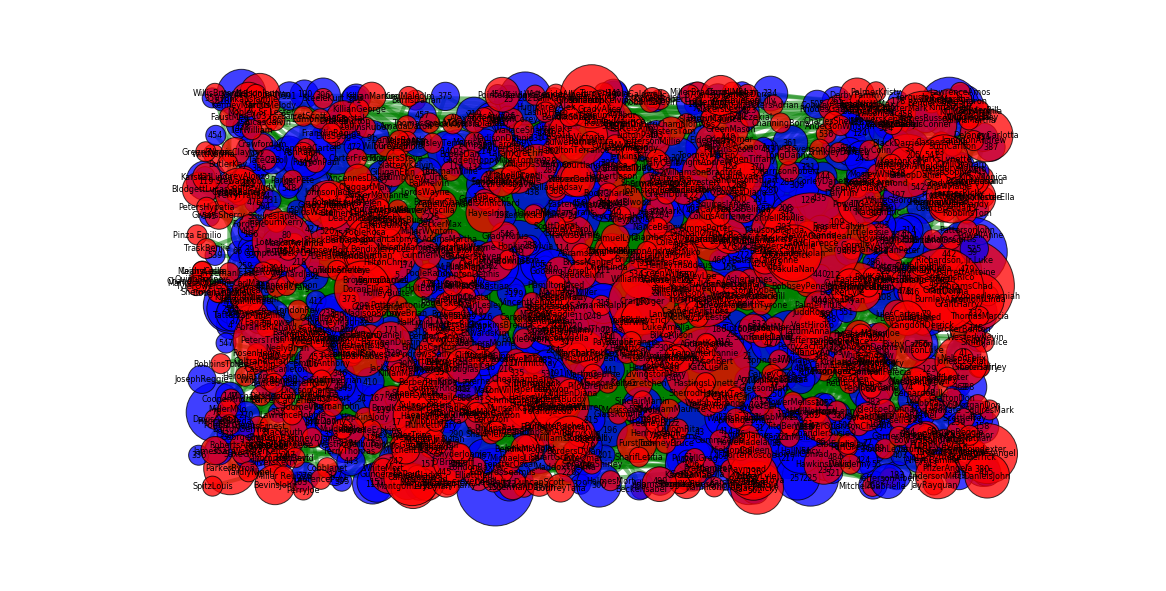

In [21]:
## plot the overall network
pos=nx.random_layout(G2) # positions for all nodes

## elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['Count'] > 10]
## esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['Count'] <= 10]

colors=[]
for n in G2.degree().keys():
    if n in G2.degree(top_nodes).keys():
        colors.append('r')
    else:
        colors.append('b')

# nodes
d = G2.degree()
nx.draw_networkx_nodes(G2,pos, node_color=colors, node_size=[v*400 for v in d.values()], alpha=0.75)

# edges
nx.draw_networkx_edges(G2,pos, width=4,alpha=0.5,edge_color='g',style='solid')
#nx.draw_networkx_edges(G2,pos,edgelist=esmall, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G2, pos, font_size=8, font_family='sans-serif')

plt.axis('off')
plt.show()

## Centrality Measures
In the table below we take the entire bipartite graph and look at the various centrality measure for each of the nodes. We do notice that each of the centrality measures gives us a similar set of nodes that show up near the top. We see that Jenny Willisand crime 110 show up as top nodes in multiple areas.

In [22]:
## utility function to get topmost nodes for each centrality function
def get_top_keys(dictionary, top):
    items = dictionary.items()
    items.sort(reverse=True, key=lambda x: x[1])
    return map(lambda x: x, items[:top])

# Betweenness centrality
bet_cen = nx.betweenness_centrality(G2)

# Degree centrality
deg_cen = nx.degree_centrality(G2)

# Closeness centrality
clo_cen = nx.closeness_centrality(G2)

# Eigenvector centrality
eig_cen = nx.eigenvector_centrality_numpy(G2)

## get the top nodes
top_bet_cen = get_top_keys(bet_cen,10)
top_clo_cen = get_top_keys(clo_cen,10)
top_eig_cen = get_top_keys(eig_cen,10)
top_deg_cen = get_top_keys(deg_cen,10)

## smush them together to make a comparison chart
smush = np.hstack((top_bet_cen, top_clo_cen, top_eig_cen, top_deg_cen))

cent_measures=pd.DataFrame(smush, columns=['Node', 'Betweenness', 'Node', 'Closeness', 'Node', 'Eigenvector', 'Node', 'Degree'])

In [23]:
cent_measures

,Node,Betweenness,Node,Closeness,Node,Eigenvector,Node,Degree
0,WillisJenny,0.371301340152,47,0.10459398284,110,0.414920959003,WillisJenny,0.0181290790428
1,110,0.323802413821,SlatteryMaurice,0.10430116125,KatzLuella,0.414200419934,AbramsChad,0.0159535895577
2,SlatteryMaurice,0.254167041696,160,0.104197650534,SteinerCatherine,0.247706311047,110,0.0130529369108
3,23,0.252747859036,WillisJenny,0.104075584259,95,0.233381396842,KatzLuella,0.0130529369108
4,160,0.240850998043,23,0.10406620639,SmithMichaelThomas,0.220285657781,DicksonCarter,0.0123277737491
5,47,0.218627557343,AbramsChad,0.102962178704,417,0.183387969713,153,0.0108774474257
6,AbramsChad,0.189192601022,SteinerCatherine,0.102070416131,419,0.153482741794,BendixJerryLee,0.010152284264
7,46,0.178797977496,HemphillBud,0.101675038165,43,0.149970388001,14,0.00942712110225
8,14,0.168593116917,KarstenMae,0.101639246548,JohnstonJustin,0.142369334492,43,0.00942712110225
9,SteinerCatherine,0.156776034373,14,0.101416118592,MitchellGrant,0.138807303369,95,0.00942712110225


# Bipartite Projection Person

### x.x Island Analysis -- Persons

In [24]:
## Implementing the Island Method to look for important subgroups. ##
def trim_edges(g, weight = 1):
    # Implements a trimming of the graph edges for the Island Analysis
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2

def island_method(g, iterations = 5):
    # Iterates through the graph removing edges and returning the number of edges removed and
    #  the trimmed graph
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [27]:
PC = nx.bipartite.weighted_projected_graph(G2, top_nodes)
cc = list(nx.connected_component_subgraphs(PC))[0]

In [28]:
## Running the Island Analysis on the graph. Will thow an error if the island_method is called with too many steps
islands = island_method(cc, iterations = 4)
print ''
print 'Depth  Persons  Networks'
print '-------------------------'
for island in islands:
    print(' %d       %2d       %2d' 
          %(island[0], len(island[1]), len(list(nx.connected_component_subgraphs(island[1]))))) 


Depth  Persons  Networks
-------------------------
 1       89       27
 2       28       12
 3       15        7
 4        6        3


## This gets us to 7 subnetworks, including one involving three people connected by the same crimes

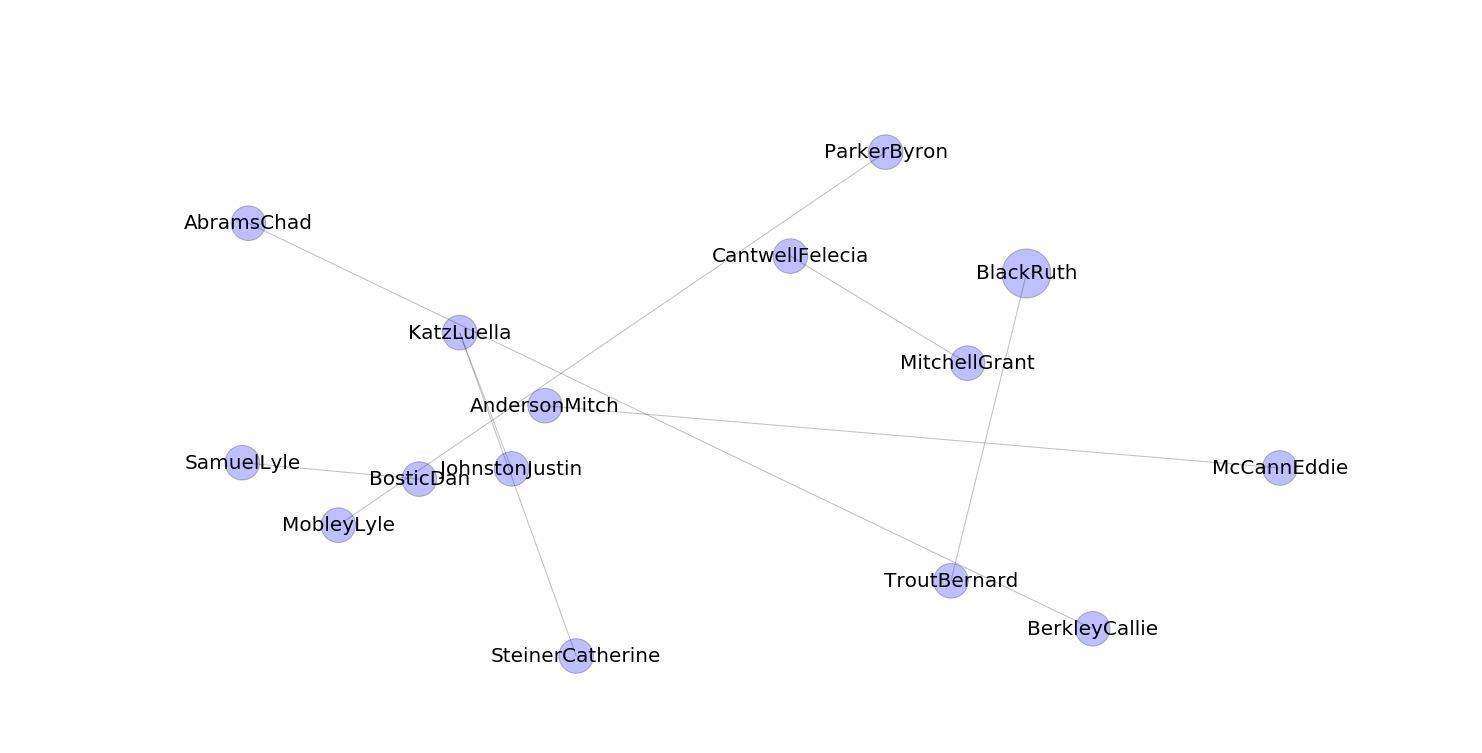

In [30]:
## Plotting created by the island analysis

pc = trim_edges(cc, 3)

dpc = pc.degree()
nx.draw_random(pc, node_size=[v*1200 for v in dpc.values()], with_labels=True, node_color='b', alpha=.25, font_size=20)

# Bipartite Projection, Crimes

In [31]:
# project bipartite graph onto crime nodes
# now the degrees are their connections with other crimes
# based on involvment by the same persons

CC = nx.bipartite.weighted_projected_graph(G2, bottom_nodes)

## x.x Island Analysis - Crimes

turns out to be interesting -- a six-node network involing the same victims/suspects. 


In [32]:
## Running the Island Analysis on the graph. Will thow an error if the island_method is called with too many steps
islands = island_method(CC, iterations = 2)
print ''
print 'Depth  Crime  Networks'
print '----------------------'
for island in islands:
    print(' %d      %3d      %2d' 
          %(island[0], len(island[1]), len(list(nx.connected_component_subgraphs(island[1])))))


Depth  Crime  Networks
----------------------
 1      119      36
 2       10       3


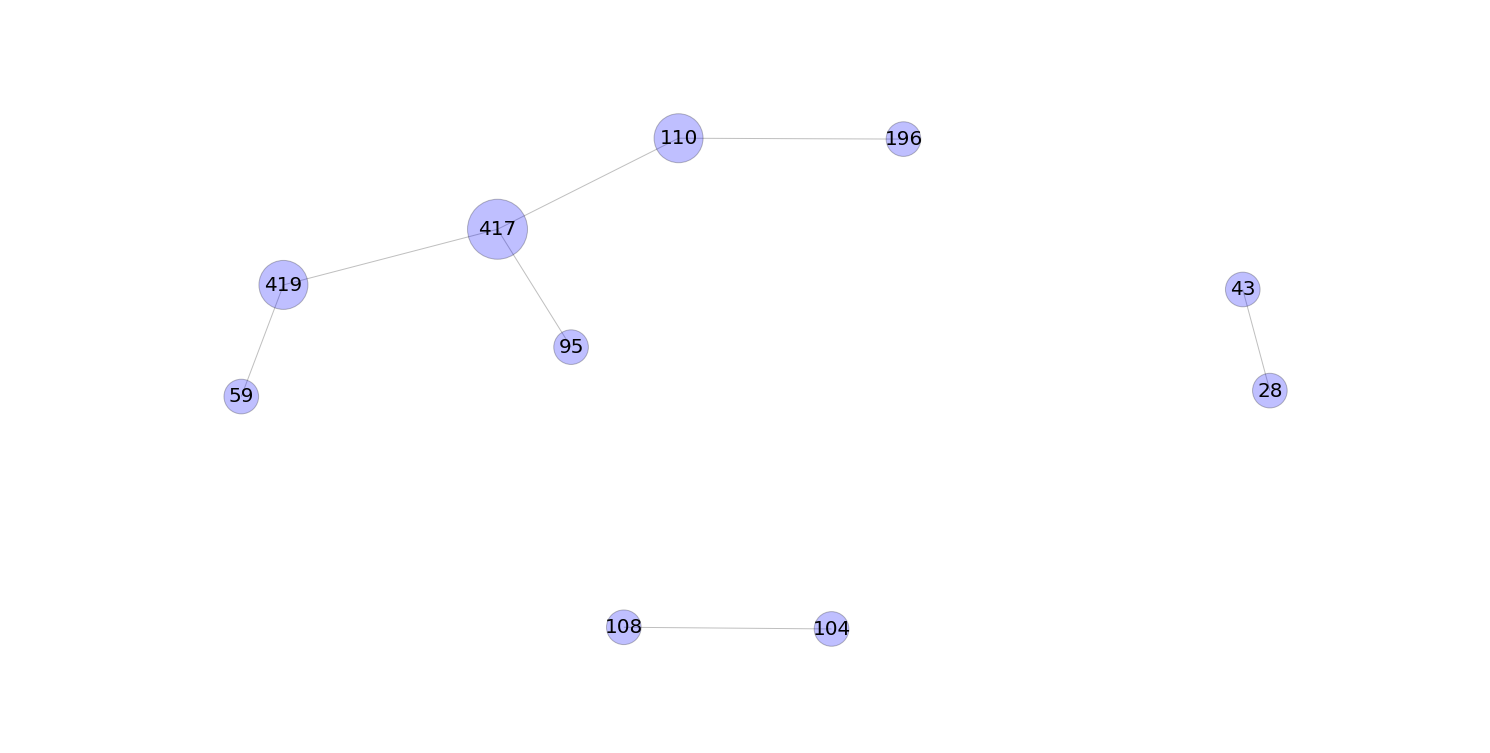

In [33]:
## Plotting the two graphs created by the island analysis

wc = trim_edges(CC, 2)
dwc = wc.degree()
nx.draw(wc, node_size=[v*1200 for v in dwc.values()], with_labels=True, node_color='b', alpha=.25, font_size=20)